In [1]:
def spherical_galaxy(N, mass, scale_length):
    '''generates the initial phase space coordinates for a Hernquist spherical galaxy in equilibrium
    ------------------------------------------------------------------------------------------------
    N [integer]: number of particles
    mass [float]: total mass of galaxy
    scale_length [float]: scale length of galaxy; radius at which density drops off substantially
    OUTPUT [NumPy array]: N x 7 array of positions, velocities, and masses of galaxy
    '''
    # import dependencies
    import numpy as np # numerical computation
    from scipy.integrate import quad # integration
    from tqdm import tqdm # progress bar
    # quantize N
    N = int(N)
    # generate array of logspaced radii from 10e-3 to 10e3 to sample from theoretical model
    R = np.logspace(-3, 3, num = 10000)
    # set model units
    M, a = 1.0, 1.0
    # calculate enclosed Mass from radius by integrating density profile
    def Enclosed_Mass(R, M, a):
        def Menc_integrand(r, M, a):
            """returns hernquist density profile for spherically symmetric galaxies"""
            return (4*np.pi*r**2) * ((M*a) / ( 2*np.pi * r*((r + a)**3) ))
        def M_enc(radii, M, a):
            """calculates the enclosed mass for a given radius"""
            return quad(Menc_integrand, 0.001, radii, args = (M, a), epsrel = 1e-5)[0]
        
        # empty array for storing enclosed mass
        enclosed_mass = np.empty(len(R))
        # for each radius, calculate enclosed mass
        for r in tqdm(range(len(R)), desc = 'Calculating Enclosed Mass: '):
            Me = M_enc(R[r], M, a)
            enclosed_mass[r] = Me
        return enclosed_mass
    
    M_enclosed = Enclosed_Mass(R, M, a)
    # generate spherically symmetric positions
    def generate_radii(N, R, enclosed_mass):
        """generates N spherically symmetric radii using inverse transform sampling"""
        # generate N uniform samples from 0 to 1 for inverse transform sampling
        samples = np.random.rand(N, 1)
        # interpolate N radii from inverse enclosed mass distribution
        radii = np.interp(samples, enclosed_mass, R)
        # generate N uniform samples from 0 to 2pi for azimuthal angles
        phi = np.random.rand(N, 1) * 2*np.pi
        # generate N uniform samples from -1 to 1 for radial angles
        x = np.random.uniform(low = -1, high = 1, size = (N, 1))
        # generate N theta angles
        theta = np.arccos(x)
        
        # generate spherically symmetric galaxy in 3D using spherical coordinates
        xpos = np.array(radii * np.sin(theta) * np.cos(phi) )
        ypos = np.array(radii * np.sin(theta) * np.sin(phi) )
        zpos = np.array(radii * np.cos(theta) )
        return np.hstack((xpos, ypos, zpos)), radii
    
    positions, radii = generate_radii(N, R, M_enclosed)
    # calulcate density for logspaced radii distribution
    def rho(r, M, a):
        """
        returns hernquist density profile for spherically symmetric galaxies
        """
        return (M*a) / ( 2*np.pi * r*((r + a)**3) )
    
    rh0 = rho(R, M, a)
    # calculate potential from radii
    def phi(r, M, a):
        """
        returns hernquist potential for spherically symmetric galaxies
        """
        # scale length, gravitational constant, and total mass in natural units
        G = 1 
        phi_potential = -( (G * M)/(r + a) )
        return phi_potential
    
    # calculate potential for each generated stellar radius
    potential_r = - phi(radii, M, a)
    # calculate potential for logspaced radii distribution
    Psi = - phi(R, M, a)
    # calculate derivatives of density with respect to potential
    def grad(u, v):
        """
        returns numpy gradient du/dv
        """
        return np.gradient(u, v)
    
    # calculate first derivative
    dr_dp = grad(rh0, Psi)
    # calculate second derivative
    d2r_dp2 = grad(dr_dp, Psi)
    
    # calculate cumulative distribution function of velocity
    def fe_a(E):
        q = np.sqrt(E)
        coefficient = ( 1/( 8*np.sqrt(2) * np.pi**3 ) )
        q_function = ( 3*np.arcsin(q) + ( q*np.sqrt(1 - q**2) * (1 - 2*q**2) * (8*q**4 - 8*q**2 - 3) ) )
        return coefficient * (1 / (1 - q**2)**(5/2)) * q_function
    
    def genV(vel, potential):
        def integrand(v, phi):
            return (v**2) * fe_a(phi - (1/2)*v**2)
        return quad(integrand, 0, vel, args = (potential), epsrel = 1e-5)[0]

    # initiate empty final velocity magnitude array
    v_magnitude = np.zeros(radii.shape[0])
    # loop through each generated stellar particle 
    for i in tqdm(range(len(radii)), desc = 'Calculating Velocity Magnitude'):
        # calculate escape speed for given particle
        v_esc = np.sqrt(2 * abs(potential_r[i]) )
        # initiate equally spaced array from 0 to escape velocity
        v_arr = np.linspace(0, v_esc, 100, endpoint = False).reshape(100)
        # loop through each velocity in array
        G_x = np.empty(len(v_arr))
        for j in range(len(v_arr)):
            cdf = genV(v_arr[j], potential_r[i])
            G_x[j] = cdf
        # normalize cdf
        G_x = G_x/np.max(G_x)
        # generate random number from 0 to 1                   
        rand = np.random.rand(1)
        # interpolate velocity from cdf using inverse transform
        velocity_mag = np.interp(rand, G_x, v_arr)
        # save velocity
        v_magnitude[i] = velocity_mag
    # generate velocity components
    def generate_velocities(v):
        N = int(v.shape[0])
        v = v.reshape(N, 1)
        phi = np.random.rand(N, 1) * 2*np.pi
        # generate N uniform samples from -1 to 1 for radial angles
        x = np.random.uniform(low = -1, high = 1, size = (N, 1))
        # generate N theta angles
        theta = np.arccos(x)

        vx = np.array(v * np.sin(theta) * np.cos(phi) )
        vy = np.array(v * np.sin(theta) * np.sin(phi) )
        vz = np.array(v * np.cos(theta) )

        return np.hstack((vx, vy, vz))
    
    velocities = generate_velocities(v_magnitude)
    # calculate stellar mass such that mass of system sums to 1
    masses = np.ones((N, 1))*M/N
    # scale the positions, velocities, and masses
    def scale_phase(pos, vel, mas, M, R):
        '''scale position, velocity, and mass by scalars R and M
        --------------------------------------------------------------------------
        pos, vel, mas [NumPy array]: initial position, velocity, and mass arrays
        R, M [float]: quantities to scale the positions, velocities, and masses by
        OUTPUT [NumPy array]: scaled position, velocity, and mass arrays
        '''
        G = 1 
        # scale position, velocity, and mass by scalar quantities. the velocities are scaled proportionally to a circular orbit velocity
        pos = pos * R
        vel = vel * np.sqrt(G*M/R)
        mas = mas * M
        return pos, vel, mas
    
    positions, velocities, masses = scale_phase(positions, velocities, masses, mass, scale_length)

    return np.hstack((positions, velocities, masses))

In [2]:
initial_phase = spherical_galaxy(15000, 1, 1)

Calculating Velocity Magnitude: 100%|█████| 15000/15000 [11:50<00:00, 21.11it/s]


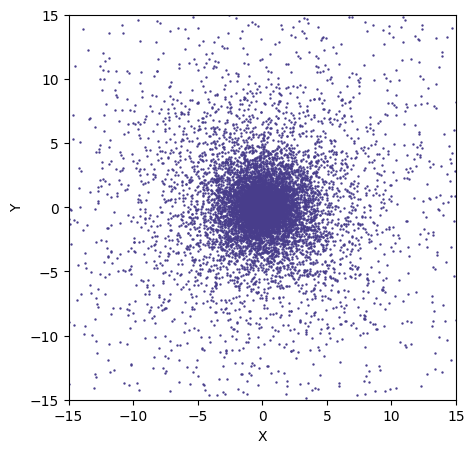

In [13]:
# display the galaxy
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
plt.scatter(initial_phase[:,0:1], initial_phase[:,1:2], s = .5, color = 'darkslateblue')
plt.xlim(-15, 15), plt.ylim(-15, 15)
plt.xlabel('X'), plt.ylabel('Y')
plt.show()

In [ ]:
# save initial conditions as .txt file
import numpy as np
np.savetxt('spherical_galaxy_15000.txt', initial_phase)